## US presidential elections model

How do macroeconomic features influence the left/right lean in US presidential elections? 

### Imports

In [9]:
# Usual stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# ML tools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
# Internal utils
from plotting import Plot 

## Load and prepare data

In [60]:
# Election winners by year
df_ele = pd.read_csv("../data/election_data.csv")
# Filter before 1960 
df_ele = df_ele[df_ele["Year"] >= 1960]
# Add label
df_ele["label"] = df_ele["Lean"].map({"Left": 0, "Right": 1})
# Display
display(df_ele)

,Year,Winner,Party,EC,PV,Lean,Era,label
0,2024,Donald Trump,Republican,0.4200,0.4834,Right,Populist,1
1,2020,Joseph Biden,Democratic,0.5688,0.5131,Left,Populist,0
2,2016,Donald Trump,Republican,0.5690,0.4620,Right,Populist,1
3,2012,Barack Obama,Democratic,0.6170,0.5110,Left,Partisan Polarisation,0
4,2008,Barack Obama,Democratic,0.6780,0.5290,Left,Partisan Polarisation,0
5,2004,George W. Bush,Republican,0.5320,0.5070,Right,Partisan Polarisation,1
6,2000,George W. Bush,Republican,0.5040,0.4790,Right,Post-Cold War,1
7,1996,William Clinton,Democratic,0.7040,0.4920,Left,Post-Cold War,0
8,1992,William Clinton,Democratic,0.6880,0.4300,Left,Post-Cold War,0
9,1988,George Bush,Republican,0.7920,0.5340,Right,Post-1960s Realignment,1


In [63]:
# World bank indicators by year https://databank.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG/1ff4a498/Popular-Indicators
df_wbind = (
    pd.read_csv("../data/world_bank_indicators_1960-2023.csv")
    .replace("..", np.nan)
    .drop(["Series Code", "Country Name", "Country Code"], axis=1)
    .rename(columns={"Series Name": "Year"})
)

# Clean column names and transpose
df_wbind.columns = df_wbind.columns.str.replace(r"\s\[YR\d{4}\]", "", regex=True)
df_wbind = df_wbind.transpose().reset_index()

# Set first row as header
df_wbind.columns = df_wbind.iloc[0]
df_wbind = df_wbind.drop(index=0)

# Convert all columns to numeric (except Year)
for col in df_wbind.columns:
    if col != "Year":
        df_wbind[col] = pd.to_numeric(df_wbind[col], errors='coerce')

# For the sake of this exercise, treat 2023 data as 2024 data
df_wbind.loc[df_wbind["Year"] == "2023", "Year"] = "2024"

# Convert Year to int for merging
df_wbind["Year"] = df_wbind["Year"].astype(int)

print(f"World Bank data shape: {df_wbind.shape}")
print(f"Years: {sorted(df_wbind['Year'].tolist())}")

display(df_wbind.head())

World Bank data shape: (64, 51)
Years: [1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2024]


,Year,"Population, total",Population growth (annual %),Surface area (sq. km),Poverty headcount ratio at national poverty lines (% of population),"GNI, Atlas method (current US$)","GNI per capita, Atlas method (current US$)","GNI, PPP (current international $)","GNI per capita, PPP (current international $)",Income share held by lowest 20%,...,Net barter terms of trade index (2015 = 100),"External debt stocks, total (DOD, current US$)",Total debt service (% of GNI),Net migration,"Personal remittances, paid (current US$)","Foreign direct investment, net inflows (BoP, current US$)",Net ODA received per capita (current US$),GDP per capita (current US$),"Foreign direct investment, net (BoP, current US$)","Inflation, consumer prices (annual %)"
1,1960,180671000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,422708,NaN,NaN,NaN,2999.864872,NaN,1.457976
2,1961,183691000,1.657730,9629090.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,580333,NaN,NaN,NaN,3059.160821,NaN,1.070724
3,1962,186538000,1.537997,9629090.0,NaN,6.076860e+11,3260.0,NaN,NaN,NaN,...,NaN,NaN,NaN,625617,NaN,NaN,NaN,3236.013112,NaN,1.198773
4,1963,189242000,1.439165,9629090.0,NaN,6.414920e+11,3390.0,NaN,NaN,5.7,...,NaN,NaN,NaN,639495,NaN,NaN,NaN,3366.369790,NaN,1.239669
5,1964,191889000,1.389046,9629090.0,NaN,6.872480e+11,3580.0,NaN,NaN,5.7,...,NaN,NaN,NaN,618635,NaN,NaN,NaN,3565.314430,NaN,1.278912


In [16]:
# FRED unemployment data https://fred.stlouisfed.org/series/UNRATE
df_emp = (
    pd.read_csv("../data/FRED_unemployment_rate_1948-2024.csv")
    .rename(columns={"UNRATE": "Unemployment"})
)

# Extract year from observation date
df_emp["observation_date"] = pd.to_datetime(df_emp["observation_date"], errors="coerce")
df_emp["Year"] = df_emp["observation_date"].dt.year

# Get yearly average unemployment rate
df_emp = (
    df_emp.groupby("Year")["Unemployment"]
    .mean()
    .reset_index()
)

# Filter to 1960 and later
df_emp = df_emp[df_emp["Year"] >= 1960]

display(df_emp)

,Year,Unemployment
12,1960,5.541667
13,1961,6.691667
14,1962,5.566667
15,1963,5.641667
16,1964,5.158333
...,...,...
72,2020,8.091667
73,2021,5.350000
74,2022,3.633333
75,2023,3.625000


In [64]:
# Merge all DataFrames on the Year column
df_comb = df_ele.merge(df_emp, on="Year").merge(df_wbind, on="Year")

print(f"Merged dataset: {df_comb.shape[0]} rows x {df_comb.shape[1]} columns")

Merged dataset: 17 rows x 59 columns


In [65]:
# Check years in each dataframe
print("Years in df_ele:", sorted(df_ele['Year'].tolist()))
print("Years in df_emp:", sorted(df_emp['Year'].tolist()))
print("Years in df_wbind:", sorted(df_wbind['Year'].tolist()))
print("\nYears after merge:", sorted(df_comb['Year'].tolist()))

Years in df_ele: [1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020, 2024]
Years in df_emp: [1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Years in df_wbind: [1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2024]

Years after merge: [1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988,

In [56]:
# Analyze missing data before dropping
print("Missing data analysis:")
print("=" * 60)

missing_counts = df_comb.isnull().sum()
missing_pct = (missing_counts / len(df_comb)) * 100

missing_df = pd.DataFrame({
    "Column": missing_counts.index,
    "Missing_Count": missing_counts.values,
    "Missing_Pct": missing_pct.values
})

# Show only columns with missing data
missing_df = missing_df[missing_df["Missing_Count"] > 0].sort_values("Missing_Pct", ascending=False)

print(f"\nTotal columns: {len(df_comb.columns)}")
print(f"Columns with missing data: {len(missing_df)}")
print(f"\nColumns that would be dropped with dropna(axis=1):")
display(missing_df)

Missing data analysis:

Total columns: 41
Columns with missing data: 0

Columns that would be dropped with dropna(axis=1):


,Column,Missing_Count,Missing_Pct


In [66]:
# Better strategy: Drop columns only if >30% missing, then interpolate remaining
print("\nApplying better missing data strategy...")

# Step 1: Drop columns with >30% missing data
threshold = 0.3
min_valid_count = int(len(df_comb) * (1 - threshold))
df_cleaned = df_comb.dropna(axis=1, thresh=min_valid_count)

print(f"Columns after dropping those with >30% missing: {len(df_cleaned.columns)}")

# Step 2: Convert Year to int for proper interpolation
df_cleaned['Year'] = df_cleaned['Year'].astype(int)

# Step 3: Identify numeric columns for interpolation
numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
non_numeric_cols = df_cleaned.select_dtypes(exclude=[np.number]).columns

# Step 4: Interpolate missing values in numeric columns
for col in numeric_cols:
    if df_cleaned[col].isnull().any():
        df_cleaned[col] = df_cleaned[col].interpolate(method='linear', limit_direction='both')

# Step 5: Check which rows still have NaN values
rows_with_nan = df_cleaned[df_cleaned.isnull().any(axis=1)]
if len(rows_with_nan) > 0:
    print(f"\nRows with remaining NaN values after interpolation:")
    print(f"Years: {rows_with_nan['Year'].tolist()}")
    print(f"\nColumns with NaN in these rows:")
    for idx in rows_with_nan.index:
        nan_cols = df_cleaned.loc[idx][df_cleaned.loc[idx].isnull()].index.tolist()
        print(f"  {df_cleaned.loc[idx, 'Year']}: {nan_cols}")

# Drop any remaining rows with NaN values
rows_before = len(df_cleaned)
df_cleaned = df_cleaned.dropna()
rows_after = len(df_cleaned)

if rows_before != rows_after:
    print(f"\nDropped {rows_before - rows_after} rows with remaining NaN values")

print(f"Remaining missing values: {df_cleaned.isnull().sum().sum()}")
print(f"Final dataset: {df_cleaned.shape[0]} rows × {df_cleaned.shape[1]} columns")

# Use the cleaned dataframe
df_comb = df_cleaned.copy()


Applying better missing data strategy...
Columns after dropping those with >30% missing: 41
Remaining missing values: 0
Final dataset: 17 rows × 41 columns


/var/folders/vd/j1ssd1m12k12xgpd02q9l0s80000gr/T/ipykernel_73421/2725625627.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Year'] = df_cleaned['Year'].astype(int)
/var/folders/vd/j1ssd1m12k12xgpd02q9l0s80000gr/T/ipykernel_73421/2725625627.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = df_cleaned[col].interpolate(method='linear', limit_direction='both')


In [67]:
# Add political binary label
df_comb["label"] = df_comb["Lean"].map({"Left": 0, "Right": 1})

# Save the improved dataset
display(df_comb)

df_comb.to_csv("../data/combined_data_1960-2020.csv", index=False)
print(f"\nSaved combined dataset: {df_comb.shape[0]} rows × {df_comb.shape[1]} columns")

,Year,Winner,Party,EC,PV,Lean,Era,label,Unemployment,"Population, total",...,Military expenditure (% of GDP),Mobile cellular subscriptions (per 100 people),Merchandise trade (% of GDP),Net barter terms of trade index (2015 = 100),Net migration,"Personal remittances, paid (current US$)","Foreign direct investment, net inflows (BoP, current US$)",GDP per capita (current US$),"Foreign direct investment, net (BoP, current US$)","Inflation, consumer prices (annual %)"
0,2024,Donald Trump,Republican,0.4200,0.4834,Right,Populist,1,4.027273,334914895,...,3.696010,104.935375,18.733583,100.000000,1322668,9.303100e+10,3.487840e+11,82769.412210,1.053000e+11,4.116338
1,2020,Joseph Biden,Democratic,0.5688,0.5131,Left,Populist,0,8.091667,331526933,...,3.696010,104.935375,17.944405,100.000000,329769,6.612600e+10,1.370660e+11,64411.373180,1.452650e+11,1.233584
2,2016,Donald Trump,Republican,0.5690,0.4620,Right,Populist,1,4.875000,323071755,...,3.422588,103.370250,19.681904,100.083472,1889129,6.287000e+10,4.743880e+11,58206.614190,-1.745730e+11,1.261583
3,2012,Barack Obama,Democratic,0.6170,0.5110,Left,Partisan Polarisation,0,8.075000,313877662,...,4.461710,96.269297,23.884792,94.680851,1632007,5.237100e+10,2.503450e+11,51784.411470,1.268950e+11,2.069337
4,2008,Barack Obama,Democratic,0.6780,0.5290,Left,Partisan Polarisation,0,5.800000,304093966,...,4.446596,85.477380,23.405290,91.797166,1416841,5.567900e+10,3.410920e+11,48570.059430,2.491000e+09,3.839100
5,2004,George W. Bush,Republican,0.5320,0.5070,Right,Partisan Polarisation,1,5.541667,292805298,...,4.016313,62.874751,19.157874,101.270772,1313467,4.435700e+10,2.136410e+11,41724.641200,1.603630e+11,2.677237
6,2000,George W. Bush,Republican,0.5040,0.4790,Right,Post-Cold War,1,3.966667,282162411,...,3.112242,38.767207,19.912473,100.000000,1248392,3.439700e+10,3.491250e+11,36329.970260,-1.627550e+11,3.376857
7,1996,William Clinton,Democratic,0.7040,0.4920,Left,Post-Cold War,0,5.408333,269394000,...,3.554982,16.373812,17.924887,103.448276,1141648,2.372320e+10,9.766000e+10,29967.712720,5.360000e+09,2.931204
8,1992,William Clinton,Democratic,0.6880,0.4300,Left,Post-Cold War,0,7.491667,256514000,...,4.970467,4.323597,15.368646,103.603604,1304880,1.615630e+10,3.031000e+10,25418.990780,2.846000e+10,3.028820
9,1988,George Bush,Republican,0.7920,0.5340,Right,Post-1960s Realignment,1,5.491667,244499000,...,6.071278,0.854125,14.933243,103.960396,460778,9.005000e+09,5.691000e+10,21417.011930,-3.520900e+10,4.077741



Saved combined dataset: 17 rows × 41 columns


## Extract features and prepare data

In [32]:
df_comb.columns

Index(['Year', 'Winner', 'Party', 'EC', 'PV', 'Lean', 'Era', 'label',
       'Unemployment', 'Population, total', 'Population growth (annual %)',
       'Surface area (sq. km)', 'GNI, Atlas method (current US$)',
       'GNI per capita, Atlas method (current US$)',
       'Income share held by lowest 20%',
       'Life expectancy at birth, total (years)',
       'Fertility rate, total (births per woman)',
       'Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Mortality rate, under-5 (per 1,000 live births)',
       'Immunization, measles (% of children ages 12-23 months)',
       'Water productivity, total (constant 2015 US$ GDP per cubic meter of total freshwater withdrawal)',
       'Energy use (kg of oil equivalent per capita)',
       'Electric power consumption (kWh per capita)', 'GDP (current US$)',
       'GDP growth (annual %)', 'Inflation, GDP deflator (annual %)',
       'Exports of goods and services (% of GDP)',
       'Imports of goods and services

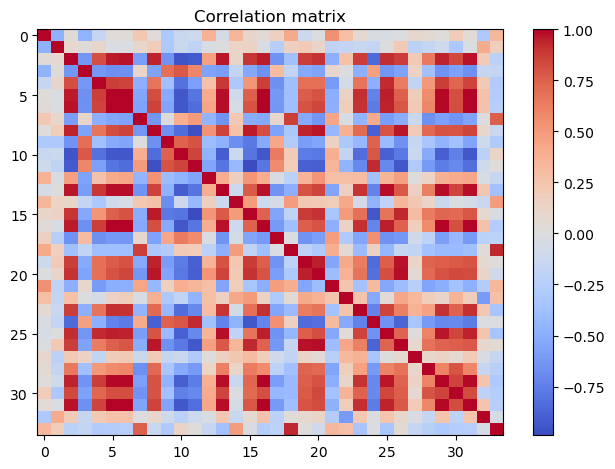

,Feature,Correlation
0,label,1.000000
1,Gross capital formation (% of GDP),0.544342
2,"Inflation, GDP deflator (annual %)",0.412917
3,"Immunization, measles (% of children ages 12-2...",0.367727
4,Energy use (kg of oil equivalent per capita),0.340180
5,"Inflation, consumer prices (annual %)",0.333160
6,"Revenue, excluding grants (% of GDP)",0.288543
7,Income share held by lowest 20%,0.222303
8,"Foreign direct investment, net inflows (BoP, c...",0.186706
9,GDP growth (annual %),0.145926


In [69]:
# Analyse correlations with target variable
exclude_columns = ["Year", "Winner", "Party", "EC", "PV", "Lean", "Era"]
df_features = df_comb.drop(columns=exclude_columns)

# Calculate correlation matrix
corr_matrix = df_features.corr()

# Plot heatmap
plt.figure() # figsize=(12, 10))
plt.imshow(corr_matrix, cmap="coolwarm", aspect="auto")
plt.colorbar()
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

# Show correlations with target label
corr_with_label = corr_matrix["label"].sort_values(ascending=False)
corr_df = pd.DataFrame({
    "Feature": corr_with_label.index,
    "Correlation": corr_with_label.values
})

display(corr_df)

In [68]:
# Prepare features for modeling (keep all numeric features)
X = df_features.drop(columns=["label"])
y = df_comb["label"]

print(f"Features for modeling: {X.shape[1]} features, {X.shape[0]} samples")

Features for modeling: 33 features, 9 samples


In [72]:
print(f"df_features shape: {df_features.shape}")
print(f"df_comb shape: {df_comb.shape}")
print(f"'label' in df_features.columns: {'label' in df_features.columns}")
print(f"df_features.columns: {df_features.columns.tolist()}")
print(f"\ndf_features head:")
display(df_features.head())
print(f"\nX shape before drop: {df_features.shape}")
X_test = df_features.drop(columns=["label"])
print(f"X shape after drop: {X_test.shape}")
print(f"y shape: {y.shape}")
print(f"Years in df_comb: {sorted(df_comb['Year'].tolist())}")

df_features shape: (17, 34)
df_comb shape: (17, 41)
'label' in df_features.columns: True
df_features.columns: ['label', 'Unemployment', 'Population, total', 'Population growth (annual %)', 'Surface area (sq. km)', 'GNI, Atlas method (current US$)', 'GNI per capita, Atlas method (current US$)', 'Income share held by lowest 20%', 'Life expectancy at birth, total (years)', 'Fertility rate, total (births per woman)', 'Adolescent fertility rate (births per 1,000 women ages 15-19)', 'Mortality rate, under-5 (per 1,000 live births)', 'Immunization, measles (% of children ages 12-23 months)', 'Water productivity, total (constant 2015 US$ GDP per cubic meter of total freshwater withdrawal)', 'Energy use (kg of oil equivalent per capita)', 'Electric power consumption (kWh per capita)', 'GDP (current US$)', 'GDP growth (annual %)', 'Inflation, GDP deflator (annual %)', 'Exports of goods and services (% of GDP)', 'Imports of goods and services (% of GDP)', 'Gross capital formation (% of GDP)', 'Re

,label,Unemployment,"Population, total",Population growth (annual %),Surface area (sq. km),"GNI, Atlas method (current US$)","GNI per capita, Atlas method (current US$)",Income share held by lowest 20%,"Life expectancy at birth, total (years)","Fertility rate, total (births per woman)",...,Military expenditure (% of GDP),Mobile cellular subscriptions (per 100 people),Merchandise trade (% of GDP),Net barter terms of trade index (2015 = 100),Net migration,"Personal remittances, paid (current US$)","Foreign direct investment, net inflows (BoP, current US$)",GDP per capita (current US$),"Foreign direct investment, net (BoP, current US$)","Inflation, consumer prices (annual %)"
0,1,4.027273,334914895,0.491925,9831510.0,2.694500e+13,80450.0,5.7,76.980488,1.6415,...,3.696010,104.935375,18.733583,100.000000,1322668,9.303100e+10,3.487840e+11,82769.41221,1.053000e+11,4.116338
1,0,8.091667,331526933,0.969000,9831510.0,2.142480e+13,64620.0,5.7,76.980488,1.6415,...,3.696010,104.935375,17.944405,100.000000,329769,6.612600e+10,1.370660e+11,64411.37318,1.452650e+11,1.233584
2,1,4.875000,323071755,0.724676,9831510.0,1.843390e+13,57060.0,5.3,78.539024,1.8205,...,3.422588,103.370250,19.681904,100.083472,1889129,6.287000e+10,4.743880e+11,58206.61419,-1.745730e+11,1.261583
3,0,8.075000,313877662,0.733600,9831510.0,1.653780e+13,52690.0,5.3,78.741463,1.8805,...,4.461710,96.269297,23.884792,94.680851,1632007,5.237100e+10,2.503450e+11,51784.41147,1.268950e+11,2.069337
4,0,5.800000,304093966,0.945865,9831510.0,1.493520e+13,49110.0,5.3,78.039024,2.0720,...,4.446596,85.477380,23.405290,91.797166,1416841,5.567900e+10,3.410920e+11,48570.05943,2.491000e+09,3.839100



X shape before drop: (17, 34)
X shape after drop: (17, 33)
y shape: (17,)
Years in df_comb: [1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020, 2024]


## Baseline logitistic regression

In [43]:
def train_model(X, y, random_state=42):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the model
    model = LogisticRegression(random_state=random_state)
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': abs(model.coef_[0])
    }).sort_values('Importance', ascending=False)
    
    return model, accuracy, feature_importance, scaler

model, accuracy, importance, scaler = train_model(X, y, random_state=99)

print('Model:', model)
print('Accuracy:', accuracy)
print('Importance:\n', importance)

Model: LogisticRegression(random_state=99)
Accuracy: 0.5
Importance:
                                               Feature  Importance
20                 Gross capital formation (% of GDP)    0.555781
11  Immunization, measles (% of children ages 12-2...    0.350424
0                                        Unemployment    0.349242
13       Energy use (kg of oil equivalent per capita)    0.336229
2                        Population growth (annual %)    0.316285
3                               Surface area (sq. km)    0.302535
22  Market capitalization of listed domestic compa...    0.277308
18           Exports of goods and services (% of GDP)    0.254522
27                                      Net migration    0.234647
17                 Inflation, GDP deflator (annual %)    0.214938
16                              GDP growth (annual %)    0.173620
23                    Military expenditure (% of GDP)    0.155709
6                     Income share held by lowest 20%    0.155187
26    

>**Note:** This baseline model is quite unstable and fluctuates between 0.5 and 1.0, depending on the random state. With only 17 elections and a 20% test split (3-4 elections), which specific elections end up in the test set dramatically affects performance. This is why LOOCV is used below for more reliable evaluation.

## Logisitic regression with leave-one-out cross validation (LOOCV)

In [70]:
def train_model(X, y, random_state=42):
    # Initialise the Leave-One-Out cross-validation
    loo = LeaveOneOut()
    
    accuracies = []
    predictions = []
    actuals = []
    feature_importances = []
    
    # Loop through each train-test split from LOO
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Scale the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train the model
        model = LogisticRegression(random_state=random_state)
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        predictions.append(y_pred[0])
        actuals.append(y_test.iloc[0])
        
        # Get feature importance for this iteration
        importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': abs(model.coef_[0])
        }).sort_values('Importance', ascending=False)
        
        feature_importances.append(importance)
    
    # Average the accuracy across all splits
    avg_accuracy = np.mean(accuracies)
    
    # Aggregate feature importances
    all_feature_importances = pd.concat(feature_importances).groupby('Feature').mean().sort_values('Importance', ascending=False)
    
    return model, avg_accuracy, all_feature_importances, scaler, predictions, actuals

model, avg_accuracy, importance, scaler, predictions, actuals = train_model(X, y, random_state=42) 

print('Model:', model)
print('Average Accuracy:', avg_accuracy)
print('Feature Importance:\n', importance)

# Show confusion matrix
cm = confusion_matrix(actuals, predictions)

print("\nConfusion Matrix:")
print("=" * 60)
print(f"                 Predicted")
print(f"                 Left  Right")
print(f"Actual  Left      {cm[0,0]:3d}    {cm[0,1]:3d}")
print(f"        Right     {cm[1,0]:3d}    {cm[1,1]:3d}")

print(f"\nClassification Report:")
print(classification_report(actuals, predictions, target_names=['Left', 'Right']))

# Show which elections were misclassified
print("\nMisclassified elections:")
print("=" * 60)
misclassified = []
for i, (actual, pred) in enumerate(zip(actuals, predictions)):
    if actual != pred:
        year = df_comb.iloc[i]['Year']
        winner = df_comb.iloc[i]['Winner']
        actual_label = 'Left' if actual == 0 else 'Right'
        pred_label = 'Left' if pred == 0 else 'Right'
        misclassified.append({
            'Year': year,
            'Winner': winner,
            'Actual': actual_label,
            'Predicted': pred_label
        })

if misclassified:
    display(pd.DataFrame(misclassified))
else:
    print("No misclassifications!")


Model: LogisticRegression(random_state=42)
Average Accuracy: 0.3333333333333333
Feature Importance:
                                                     Importance
Feature                                                       
Net barter terms of trade index (2015 = 100)          0.638744
Revenue, excluding grants (% of GDP)                  0.492575
Foreign direct investment, net (BoP, current US$)     0.414379
Military expenditure (% of GDP)                       0.412957
Gross capital formation (% of GDP)                    0.371256
Inflation, consumer prices (annual %)                 0.242277
Unemployment                                          0.179131
Merchandise trade (% of GDP)                          0.176733
Population growth (annual %)                          0.165036
Exports of goods and services (% of GDP)              0.151410
Foreign direct investment, net inflows (BoP, cu...    0.150156
Fertility rate, total (births per woman)              0.140880
GNI per capita, A

,Year,Winner,Actual,Predicted
0,2024,Donald Trump,Right,Left
1,2020,Joseph Biden,Left,Right
2,2008,Barack Obama,Left,Right
3,2004,George W. Bush,Right,Left
4,2000,George W. Bush,Right,Left
5,1996,William Clinton,Left,Right


## Regularized Logistic Regression with LOOCV

Strong regularization to handle overfitting with 32 features and only 17 samples.

In [52]:
from sklearn.metrics import confusion_matrix, classification_report

def train_regularized_model(X, y, C=0.01, random_state=42):
    """Train with L1 regularization (Lasso) for automatic feature selection"""
    loo = LeaveOneOut()
    
    accuracies = []
    predictions = []
    actuals = []
    feature_importances = []
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Scale
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train with L1 regularization (C controls strength - lower = stronger)
        model = LogisticRegression(penalty='l1', solver='liblinear', C=C, random_state=random_state, max_iter=1000)
        model.fit(X_train_scaled, y_train)
        
        # Predict
        y_pred = model.predict(X_test_scaled)
        
        # Store results
        accuracies.append(accuracy_score(y_test, y_pred))
        predictions.append(y_pred[0])
        actuals.append(y_test.iloc[0])
        
        # Feature importance
        importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': abs(model.coef_[0])
        }).sort_values('Importance', ascending=False)
        feature_importances.append(importance)
    
    avg_accuracy = np.mean(accuracies)
    all_feature_importances = pd.concat(feature_importances).groupby('Feature').mean().sort_values('Importance', ascending=False)
    
    # Get features actually used (non-zero coefficients) - lower threshold
    active_features = all_feature_importances[all_feature_importances['Importance'] > 1e-6]
    
    return model, avg_accuracy, all_feature_importances, predictions, actuals

# Try different regularization strengths
print("Testing different regularization strengths:")
print("=" * 60)

results = []
for C in [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]:
    model, acc, features_all, preds, acts = train_regularized_model(X, y, C=C)
    active = features_all[features_all['Importance'] > 1e-6]
    results.append({'C': C, 'Accuracy': acc, 'Active': len(active)})
    print(f"\nC = {C:>5.2f}: Accuracy = {acc:.3f}, Active features = {len(active)}/{len(X.columns)}")

# Find best C based on accuracy
results_df = pd.DataFrame(results)
best_idx = results_df['Accuracy'].idxmax()
best_C = results_df.loc[best_idx, 'C']

print("\n" + "=" * 60)
print(f"\nBest regularization: C = {best_C} (Accuracy = {results_df.loc[best_idx, 'Accuracy']:.3f})")

# Train with best C
model, avg_accuracy, all_features, predictions, actuals = train_regularized_model(X, y, C=best_C)

print(f"\nTop 15 features by importance:")
display(all_features.head(15))

Testing different regularization strengths:

C =  0.01: Accuracy = 0.444, Active features = 0/33

C =  0.10: Accuracy = 0.444, Active features = 0/33

C =  0.50: Accuracy = 1.000, Active features = 2/33

C =  1.00: Accuracy = 1.000, Active features = 7/33

C =  5.00: Accuracy = 0.667, Active features = 12/33

C = 10.00: Accuracy = 0.667, Active features = 12/33


Best regularization: C = 0.5 (Accuracy = 1.000)

Top 15 features by importance:


,Importance
Feature,
Gross capital formation (% of GDP),0.775529
"Inflation, GDP deflator (annual %)",0.010098
Net barter terms of trade index (2015 = 100),0.000000
Market capitalization of listed domestic companies (% of GDP),0.000000
Merchandise trade (% of GDP),0.000000
Military expenditure (% of GDP),0.000000
Mobile cellular subscriptions (per 100 people),0.000000
"Mortality rate, under-5 (per 1,000 live births)",0.000000
Net migration,0.000000


In [53]:
# Show confusion matrix
cm = confusion_matrix(actuals, predictions)

print("\nConfusion Matrix:")
print("=" * 60)
print(f"                 Predicted")
print(f"                 Left  Right")
print(f"Actual  Left      {cm[0,0]:3d}    {cm[0,1]:3d}")
print(f"        Right     {cm[1,0]:3d}    {cm[1,1]:3d}")

print(f"\nClassification Report:")
print(classification_report(actuals, predictions, target_names=['Left', 'Right']))

# Show which elections were misclassified
print("\nMisclassified elections:")
print("=" * 60)
misclassified = []
for i, (actual, pred) in enumerate(zip(actuals, predictions)):
    if actual != pred:
        year = df_comb.iloc[i]['Year']
        winner = df_comb.iloc[i]['Winner']
        actual_label = 'Left' if actual == 0 else 'Right'
        pred_label = 'Left' if pred == 0 else 'Right'
        misclassified.append({
            'Year': year,
            'Winner': winner,
            'Actual': actual_label,
            'Predicted': pred_label
        })

if misclassified:
    display(pd.DataFrame(misclassified))
else:
    print("No misclassifications!")


Confusion Matrix:
                 Predicted
                 Left  Right
Actual  Left        4      0
        Right       0      5

Classification Report:
              precision    recall  f1-score   support

        Left       1.00      1.00      1.00         4
       Right       1.00      1.00      1.00         5

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9


Misclassified elections:
No misclassifications!


## Random forest with LOOCV

In [45]:
def train_model(X, y, random_state=42):
    loo = LeaveOneOut()
    accuracies = []
    feature_importances = []
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Scale the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train the model
        model = RandomForestClassifier(random_state=random_state)
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        
        # Get feature importance for this iteration
        importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        feature_importances.append(importance)
    
    avg_accuracy = np.mean(accuracies)
    all_feature_importances = pd.concat(feature_importances).groupby('Feature').mean().sort_values('Importance', ascending=False)
    
    return model, avg_accuracy, all_feature_importances, scaler

model, avg_accuracy, importance, scaler = train_model(X, y)

print('Model:', model)
print('Average Accuracy:', avg_accuracy)
print('Feature Importance:\n', importance)


Model: RandomForestClassifier(random_state=42)
Average Accuracy: 0.5555555555555556
Feature Importance:
                                                     Importance
Feature                                                       
Gross capital formation (% of GDP)                    0.091578
Inflation, GDP deflator (annual %)                    0.071801
Energy use (kg of oil equivalent per capita)          0.068331
Exports of goods and services (% of GDP)              0.060975
Population growth (annual %)                          0.052050
Foreign direct investment, net (BoP, current US$)     0.049475
Inflation, consumer prices (annual %)                 0.039100
Electric power consumption (kWh per capita)           0.038115
Life expectancy at birth, total (years)               0.036930
GDP growth (annual %)                                 0.035862
Personal remittances, paid (current US$)              0.035745
Unemployment                                          0.030201
Mobile cellul

## SVM with LOOCV

In [46]:
def train_model(X, y, random_state=42):
    loo = LeaveOneOut()
    accuracies = []
    feature_importances = []
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Scale the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train the model (using SVM)
        # model = SVC(random_state=random_state)
        # model.fit(X_train_scaled, y_train)

        # Train the model (using linear SVM)
        model = SVC(kernel='linear', random_state=random_state)
        model.fit(X_train_scaled, y_train)

        
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        
        # SVM doesn't have feature importances directly, so we'll use coefficients
        importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': np.abs(model.coef_[0])  # Taking absolute values of the coefficients
        }).sort_values('Importance', ascending=False)
        
        feature_importances.append(importance)
    
    avg_accuracy = np.mean(accuracies)
    all_feature_importances = pd.concat(feature_importances).groupby('Feature').mean().sort_values('Importance', ascending=False)
    
    return model, avg_accuracy, all_feature_importances, scaler

model, avg_accuracy, importance, scaler = train_model(X, y)

print('Model:', model)
print('Average accuracy:', avg_accuracy)
print('Feature importance:\n', importance)


Model: SVC(kernel='linear', random_state=42)
Average accuracy: 0.5555555555555556
Feature importance:
                                                     Importance
Feature                                                       
Gross capital formation (% of GDP)                    0.333262
Population growth (annual %)                          0.246285
Exports of goods and services (% of GDP)              0.242768
Inflation, GDP deflator (annual %)                    0.222186
Foreign direct investment, net inflows (BoP, cu...    0.185273
Energy use (kg of oil equivalent per capita)          0.184475
Market capitalization of listed domestic compan...    0.151704
Surface area (sq. km)                                 0.151400
Military expenditure (% of GDP)                       0.147321
Income share held by lowest 20%                       0.143819
Adolescent fertility rate (births per 1,000 wom...    0.132152
Immunization, measles (% of children ages 12-23...    0.126751
Unemployment   